# IE Pyrace - Performance Analysis

In [1]:
VERSION_NAME = 'QT_v02' # the name for our model
episode = 5000
episode = 35000
QTABLE =f'models_{VERSION_NAME}/q_table_{episode}.npy'
MEMORY =f'models_{VERSION_NAME}/memory_{episode}.npy'

In [2]:
#import required libraries
import numpy as np
import pandas as pd

last = 0
ep = 0
episodes = []
data = np.load(MEMORY,allow_pickle=True) # loading Object arrays
for i in range(data.shape[0]):
    if data[i,4]:
        ep += 1
        # print(ep,last,i,i-last,data[i])
        episodes.append([ep,i-last,data[i][2]])
        last = i

df = pd.DataFrame(data=episodes, index=None, columns=['episode','steps','reward'])   
# df

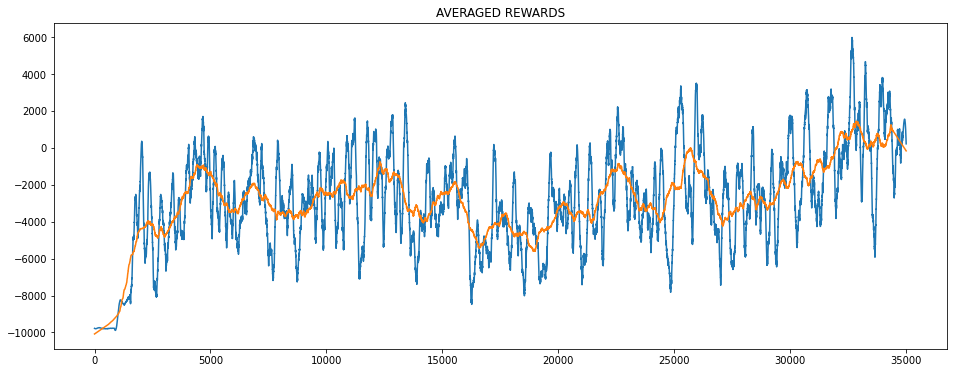

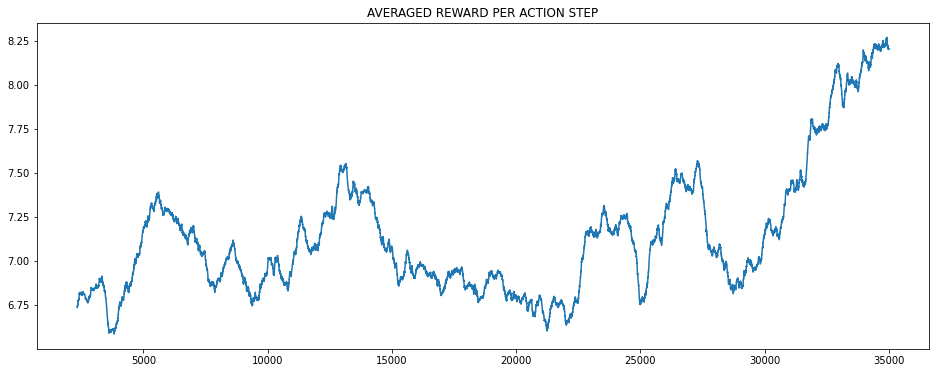

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
yhat0 = savgol_filter(df.reward, int(episode/120), 3) # window size 50, polynomial order 3
yhat1 = savgol_filter(df.reward, int(episode/30), 1)

plt.figure(figsize=(16,6))
# plt.plot(df.episode,df.reward)
plt.plot(df.episode,yhat0)
plt.plot(df.episode,yhat1)
plt.title('AVERAGED REWARDS')
plt.show()

plt.figure(figsize=(16,6))
df['z'] = np.where(df.reward > 0, (df.reward)/df.steps, (10000+df.reward)/df.steps)
plt.plot(df.z.rolling(window=int(episode/15)).mean())
plt.title('AVERAGED REWARD PER ACTION STEP')
plt.show()

## Visualizing the policy

### Tests of different forms of aggregation and scaling

In [4]:
import numpy as np
import scipy
from sklearn import preprocessing

np.set_printoptions(precision=3)
data = np.load(QTABLE,allow_pickle=True) # loading Object arrays
print(data.shape)
print('sparsity',F'{np.count_nonzero(data == 0)/data.size*100:.2f}')

# axes 0..4 bucket values in each of the radar directions, axis=5 the 3 possible actions

s0 = data.sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=1)/11/11/11/11
s1 = data.sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=0)/11/11/11/11
s2 = data.sum(axis=4).sum(axis=3).sum(axis=1).sum(axis=0)/11/11/11/11
s3 = data.sum(axis=4).sum(axis=2).sum(axis=1).sum(axis=0)/11/11/11/11
s4 = data.sum(axis=3).sum(axis=2).sum(axis=1).sum(axis=0)/11/11/11/11
print('s0',s0.shape)

def softmaxv(vec):
    exp = np.exp(vec)
    prob = exp / np.sum(exp)
    return prob

# Examples with uni-dimensional tensor
print('EXAMPLES WITH UNI-DIMENSIONAL TENSOR')
z = s0
print('DATA',z[0])
z_norm = preprocessing.normalize(z[0].reshape(1, -1)) # equivalent to normalize([s[0]])

"""
Reshape your data either using 
array.reshape(-1, 1) if your data has a single feature or 
array.reshape(1, -1) if it contains a single sample.
"""
s_minmax = preprocessing.MinMaxScaler()
z_minmax = s_minmax.fit_transform(z[0].reshape(-1, 1)).reshape(1, -1)
s_stdsc = preprocessing.StandardScaler()
z_stdsc = s_stdsc.fit_transform(z[0].reshape(-1, 1)).reshape(1, -1)

print('NORMALIZE',z_norm)
print('MINMAX SCALER',z_minmax)
print('STD SCALER',z_stdsc)
print('softmaxv',softmaxv(z[0]))
print('scipy',scipy.special.softmax(z[0]))

print('EXAMPLES WITH TWO-DIMENSIONAL TENSOR')
print('DATA\n',z)
z_norm = preprocessing.normalize(z)
print('NORMALIZE\n',z_norm)
print('scipy\n',scipy.special.softmax(z_norm,axis=1))
z_minmax = s_minmax.fit_transform(z.T).T
print('MINMAX\n',z_minmax)
print('scipy\n',scipy.special.softmax(z_minmax,axis=1))
z_stdsc = s_stdsc.fit_transform(z.T).T
print('standard\n',z_stdsc)
print('scipy\n',scipy.special.softmax(z_stdsc,axis=1))

(11, 11, 11, 11, 11, 3)
sparsity 98.73
s0 (11, 3)
EXAMPLES WITH UNI-DIMENSIONAL TENSOR
DATA [-18.328 -10.689  -5.085]
NORMALIZE [[-0.84  -0.49  -0.233]]
MINMAX SCALER [[0.    0.577 1.   ]]
STD SCALER [[-1.282  0.125  1.157]]
softmaxv [1.766e-06 3.668e-03 9.963e-01]
scipy [1.766e-06 3.668e-03 9.963e-01]
EXAMPLES WITH TWO-DIMENSIONAL TENSOR
DATA
 [[ -18.328  -10.689   -5.085]
 [-126.73  -105.854 -101.534]
 [-227.94  -204.131 -199.079]
 [-245.299 -225.553 -181.509]
 [-141.124 -107.743  -90.338]
 [ -40.296  -30.671  -26.881]
 [ -18.756  -17.124  -11.446]
 [ -13.471  -14.544  -10.942]
 [ -18.356  -14.937  -12.953]
 [ -28.534  -23.296  -25.052]
 [ -61.543  -45.54   -42.948]]
NORMALIZE
 [[-0.84  -0.49  -0.233]
 [-0.654 -0.546 -0.524]
 [-0.624 -0.559 -0.545]
 [-0.646 -0.594 -0.478]
 [-0.708 -0.541 -0.453]
 [-0.703 -0.535 -0.469]
 [-0.673 -0.615 -0.411]
 [-0.595 -0.642 -0.483]
 [-0.68  -0.554 -0.48 ]
 [-0.641 -0.523 -0.562]
 [-0.701 -0.519 -0.489]]
scipy
 [[0.235 0.334 0.431]
 [0.307 0.342 0.35

### Average aggregation + MinMax Scaling + Softmax

In [5]:
# TRANSFORM ALL DIRECTION TENSORS
sz = np.array([scipy.special.softmax(s_minmax.fit_transform(s0.T).T,axis=1),
               scipy.special.softmax(s_minmax.fit_transform(s1.T).T,axis=1),
               scipy.special.softmax(s_minmax.fit_transform(s2.T).T,axis=1),
               scipy.special.softmax(s_minmax.fit_transform(s3.T).T,axis=1),
               scipy.special.softmax(s_minmax.fit_transform(s4.T).T,axis=1)])

### Visualization

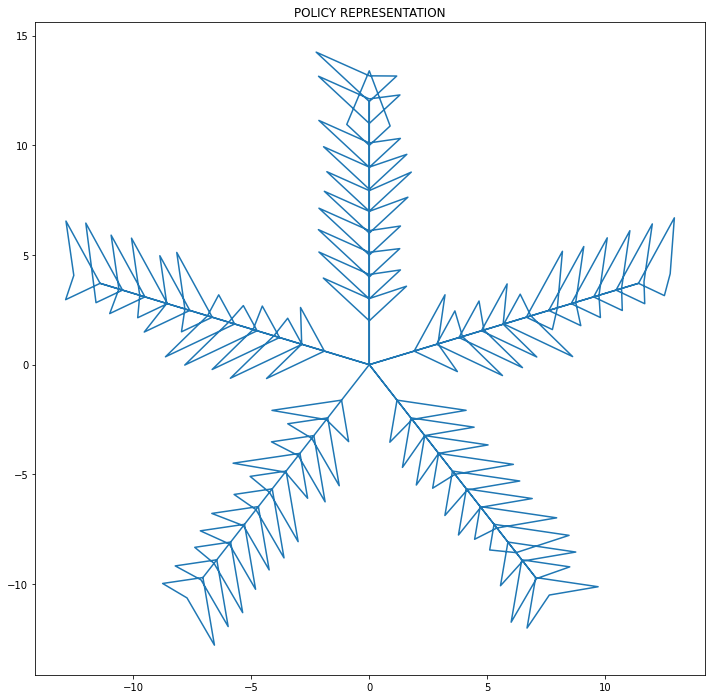

In [6]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from random import random

α=0
β=0
γ=0
ρ=0

xs = []
ys = []

for a in range(5): # 0 is rigth... 4 is left
    α = (90+(a-2)*360/5)*math.pi/180
    xs.append(0)
    ys.append(0)
    for r in range(11):
        ρ = r + 2
        x0 = ρ*math.cos(α)
        y0 = ρ*math.sin(α)
        xs.append(x0)
        ys.append(y0)
        for b in [1,0,2]:
            g = -1 if b==2 else b
            β = -45*g*math.pi/180
            x = x0 + 3 * math.cos(α+β) * sz[a][r][b] * 2
            y = y0 + 3 * math.sin(α+β) * sz[a][r][b] * 2
            xs.append(x)
            ys.append(y)
        xs.append(x0)
        ys.append(y0)

plt.figure(figsize=(12,12))        
plt.plot(xs, ys)
plt.title('POLICY REPRESENTATION')
plt.show()